# HCI 2017 Final Exam

*Matthew Kenworthy // Leiden Observatory*

This is the final exam for the HCI 2017 course.

There are four data cubes that contain the image of an exoplanet, named ``c01.fits.gz`` through to ``c04.fits.gz``.

Answer the questions fully in English in a cell after the question. There are 10 points in total on this exam.

You must email this Notebook with YOUR_NAME replaced with your name and emailed to ``quiroganunez@strw.leidenuniv.nl``

### DEADLINE IS 11:59 on TUESDAY 12 DECEMBER

  * The notebook **must compile cleanly** (``Cell => All Output=> Clear`` and then ``Cell => Run All`` must produce all your graphs and plots and images without an error) and should contain all subroutines required for data reduction.
  
##  If the Notebook does **NOT** complile cleanly, you will LOSE MARKS on this Final Exam.

  * All graphs and plots **MUST** be labelled with quantities and units.
  
  
**Q1 (1 point)** What diversity is being used in this data?

In [1]:
'''As can be seen from the data cubes with DS9 the diversity being used is Spectral. 
The speckles depend linearly on the wavelength, so this will helps us out to subtract
them without affecting the star's and planet's PSFs repectively. The method to be used is the 
Spectral Differential Imaging.'''

"As can be seen from the data cubes with DS9 the diversity being used is Spectral. \nThe speckles depend linearly on the wavelength, so this will helps us out to subtract\nthem without affecting the star's and planet's PSFs repectively. The method to be used is the \nSpectral Differential Imaging."

In [2]:
#Functions and regular python packages to be used

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, clobber=True)
    
def cen_scale (im, sca, dim_out, offset_in=(0,0), offset_out=(0,0), order=2):
    """cen_scale - scales image im at the coordinates of offset1 by factor sca
                   to output image with size dim_out, and puts the point at offset1 
                   in the centre of the output image, with an optional delta offset of offset2
                
                """
    from scipy.ndimage import affine_transform
    # make a scaling matrix
    scale=np.array([[1./sca,0],[0,1./sca]])
    
    # -0.5 is there for fencepost counting error
    c_in = np.array(offset_in) - 0.5

    # c_out already starts at the centre of the output image
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-scaled to make offset correct
    offset_combined = c_in - c_out.dot(scale) - np.array(offset_out).dot(scale)
    
    # perform the transformation
    dst=affine_transform( \
        im,scale.T, order=order, offset=offset_combined, \
        output_shape=dim_out, cval=0.0)
    return(dst)

def descale(imin, scalefac, out_dims, star_cen):
    """descale - take image imin and a list of magnifications scalefac, and generate an output image of 
       size outdims (where outdims is a tuple) and the scaling is done around the point star_cen.
       star_cen is a tuple of (xstar, ystar) positions and 
       xstar/ystar should be a numpy array or a numpy single value"""
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # sx and sy should be a single pair or contain scalefac.size number of elements
    sx, sy = star_cen
    if (sx.size == 1):
        sx = np.ones_like(scalefac) * sx
    if (sy.size == 1):
        sy = np.ones_like(scalefac) * sy
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_scale(frame_sq, scalefac[j], out_dims, offset_in=(sx[j], sy[j]))
        im_out[j,:,:] = frame_rot
        
    return(im_out)   

def sat_spot_read(Header):
    # SATSn_m with n from 0 to 36 and m from 1 to 4
    ns = 4
    nw = 37
    
    spotx = np.zeros((nw, ns))
    spoty = np.zeros((nw, ns))
    
    for i in range(nw):
        
        for j in range(ns):
            
            X, Y = np.fromstring(Header['SATS%d_%d'%(i,j)], dtype = float, sep = ' ')
            spotx[i][j] = X
            spoty[i][j] = Y

    return(spotx, spoty) 

**Q2 (2 points)** Analyse ``c01.fits.gz`` using one of the algorithms covered in the course and produce a data cube with images that are 250 by 250 pixels with the central star in the centre of the image. 

Print out the `shape()` of the data cube to show that you have the correct dimensions.

In [3]:
Im_1, He_1 = fits.getdata('c01.fits.gz', header = True) #Data cubes containing the exoplanet
Im_2, He_2 = fits.getdata('c02.fits.gz', header = True)
Im_3, He_3 = fits.getdata('c03.fits.gz', header = True)
Im_4, He_4 = fits.getdata('c04.fits.gz', header = True)

Im_1 = np.nan_to_num(Im_1) #Avoiding NAN-values in the images
Im_2 = np.nan_to_num(Im_2)
Im_3 = np.nan_to_num(Im_3)
Im_4 = np.nan_to_num(Im_4)

Spot 0, (X,Y) (98.423000, 154.243000)
Spot 1, (X,Y) (122.409000, 95.720000)
Spot 2, (X,Y) (154.966000, 184.910000)
Spot 3, (X,Y) (183.351000, 124.298000)


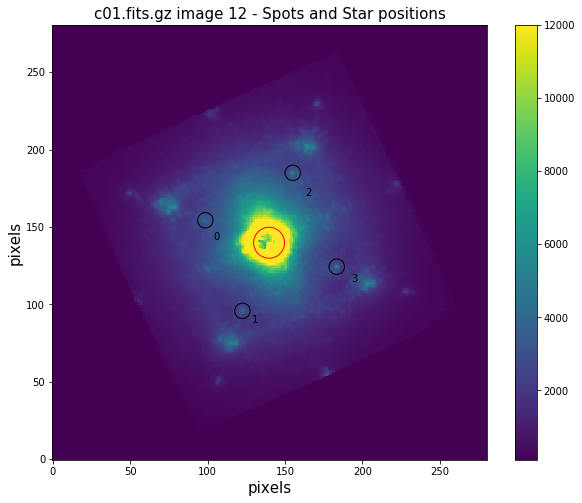

In [4]:
#Checking Spot and star position for Cube-1

# plt.figure(figsize = (10,8))
# plt.imshow(Im_1[12], vmin = 100, vmax = 12000, cmap = 'viridis') 
# plt.xlabel('pixels', size = 15)
# plt.ylabel('pixels', size = 15)
# plt.title('c01.fits.gz image 12', size = 15)
# plt.colorbar()

plt.figure(figsize = (10,8))

X_star = He_1['PSFCENTX']
Y_star = He_1['PSFCENTY']

for i in range(4):
    
    [X,Y] = np.fromstring(He_1['SATS12_%d'%i], dtype = float, sep = ' ')
    print('Spot %i, (X,Y) (%f, %f)'%(i,X,Y))
    
    Circle = plt.Circle((X, Y), 5, color = 'k', fill = False)
    Star   = plt.Circle((X_star, Y_star), 10, color = 'r', fill = False)
    ax = plt.gca()
    A = ax.imshow(Im_1[12], vmin = 100, vmax = 12000)
    ax.add_artist(Circle)
    ax.text(X + 0.05*X, Y - 0.08*Y, '%d'%i, color = 'k')
    
ax.add_artist(Star)
ax.set_xlabel('pixels', size = 15)
ax.set_ylabel('pixels', size = 15)
plt.title('c01.fits.gz image 12 - Spots and Star positions', size = 15)
plt.colorbar(A, ax = ax);

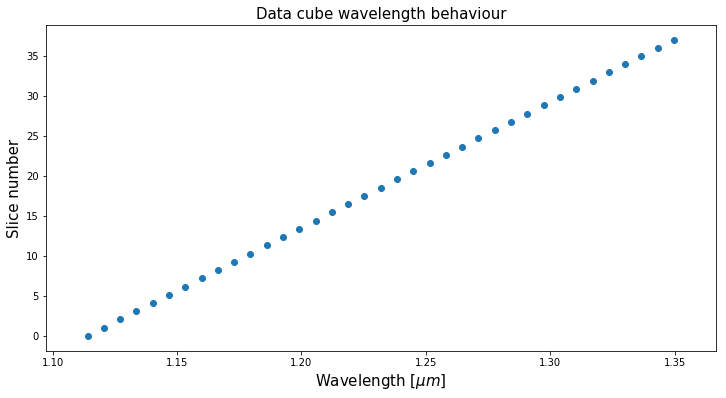

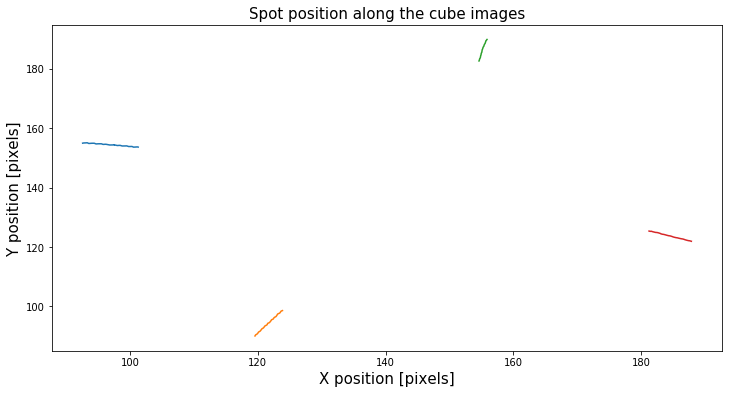

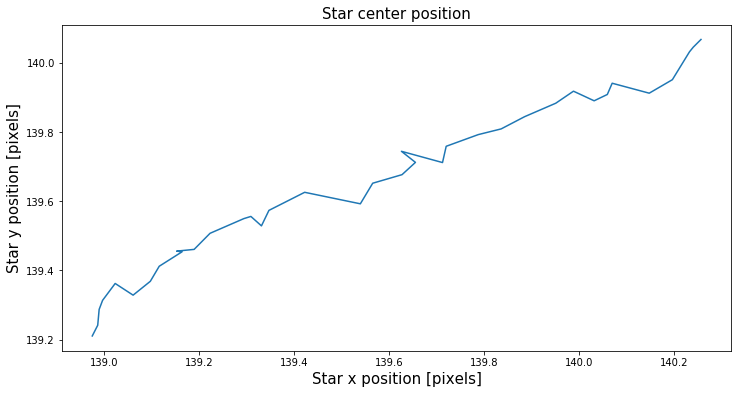

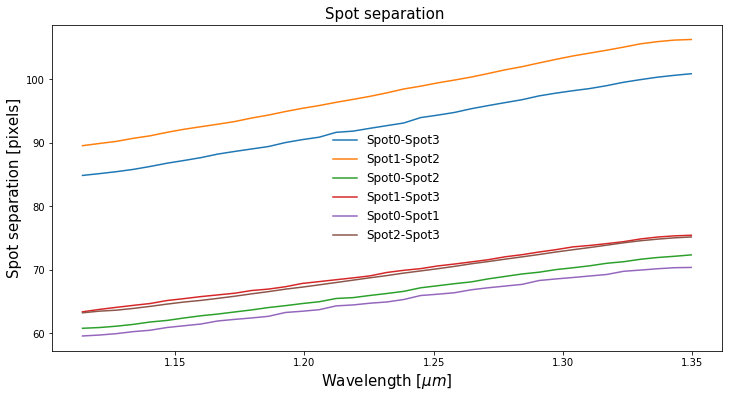

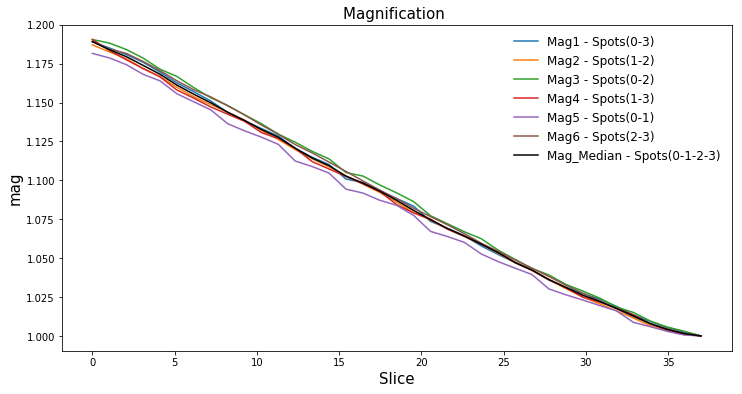

In [5]:
#General analysis for images in cube-1

wlen0 = He_1['CRVAL3']
dwlen = He_1['CD3_3']

Slice_number = np.linspace(0, 37, 37)
Wavelength = []
for i in range(37):
    Wavelength.append(wlen0 + dwlen*i)
    
Wavelength = np.array(Wavelength)

plt.figure(figsize = (12, 6))    
plt.scatter(Wavelength, Slice_number)
plt.ylabel('Slice number', size = 15)
plt.title('Data cube wavelength behaviour', size = 15)
plt.xlabel(r'Wavelength [$\mu m$]', size = 15);

#Spot positions
x, y = sat_spot_read(He_1)  

#The spots positions in this case are well-behaved so I am going to use 
#the distance between all the possible combinations for the four spots 
#in order to calculate the magnification.

plt.figure(figsize = (12, 6))
plt.plot(x, y)
plt.xlabel('X position [pixels]', size = 15)
plt.ylabel( 'Y position [pixels]', size = 15)
plt.title('Spot position along the cube images', size = 15);

star_xcen = []
star_ycen = []

for i in range(37):
    
    star_xcen.append(np.mean([x[i][0], x[i][1], x[i][2], x[i][3]]))
    star_ycen.append(np.mean([y[i][0], y[i][1], y[i][2], y[i][3]]))
    
star_xcen = np.array(star_xcen)
star_ycen = np.array(star_ycen) 

plt.figure(figsize = (12, 6))
plt.plot(star_xcen, star_ycen)
plt.xlabel('Star x position [pixels]', size = 15)
plt.ylabel('Star y position [pixels]', size = 15)
plt.title('Star center position', size = 15);

spot_separation_1 = []
spot_separation_2 = []
spot_separation_3 = []
spot_separation_4 = []
spot_separation_5 = []
spot_separation_6 = []

for k in range(37):
    
    Sp_0 = np.array([x[k][0], y[k][0]])
    Sp_1 = np.array([x[k][1], y[k][1]])
    Sp_2 = np.array([x[k][2], y[k][2]])
    Sp_3 = np.array([x[k][3], y[k][3]])

   
    spot_separation_1.append(np.linalg.norm(Sp_3-Sp_0))
    spot_separation_2.append(np.linalg.norm(Sp_2-Sp_1))
    spot_separation_3.append(np.linalg.norm(Sp_0-Sp_2))  #All possible distance combiantions
    spot_separation_4.append(np.linalg.norm(Sp_1-Sp_3))
    spot_separation_5.append(np.linalg.norm(Sp_1-Sp_0))
    spot_separation_6.append(np.linalg.norm(Sp_2-Sp_3))

    
spot_separation_1 = np.array(spot_separation_1)  
spot_separation_2 = np.array(spot_separation_2)
spot_separation_3 = np.array(spot_separation_3)
spot_separation_4 = np.array(spot_separation_4)
spot_separation_5 = np.array(spot_separation_5)
spot_separation_6 = np.array(spot_separation_6)

plt.figure(figsize = (12, 6))
plt.plot(Wavelength, spot_separation_1, label = 'Spot0-Spot3')
plt.plot(Wavelength, spot_separation_2, label = 'Spot1-Spot2')
plt.plot(Wavelength, spot_separation_3, label = 'Spot0-Spot2')
plt.plot(Wavelength, spot_separation_4, label = 'Spot1-Spot3')
plt.plot(Wavelength, spot_separation_5, label = 'Spot0-Spot1')
plt.plot(Wavelength, spot_separation_6, label = 'Spot2-Spot3')
plt.xlabel(r'Wavelength [$\mu m$]', size = 15)
plt.ylabel('Spot separation [pixels]', size = 15)
plt.title('Spot separation ', size = 15)
plt.legend(frameon = False, prop={'size': 12});

mag_1 = spot_separation_1[-1] / spot_separation_1
mag_2 = spot_separation_2[-1] / spot_separation_2
mag_3 = spot_separation_3[-1] / spot_separation_3            #All possible magnification factors
mag_4 = spot_separation_4[-1] / spot_separation_4
mag_5 = spot_separation_5[-1] / spot_separation_5
mag_6 = spot_separation_6[-1] / spot_separation_6

Med_mag = []

for i in range(len(mag_1)):
    Med_mag.append(np.median([mag_1[i], mag_2[i], mag_3[i], mag_4[i], mag_5[i], mag_6[i]]))
    
Med_mag = np.array(Med_mag)

plt.figure(figsize = (12, 6))
plt.plot(Slice_number, mag_1, label = 'Mag1 - Spots(0-3)')
plt.plot(Slice_number, mag_2, label = 'Mag2 - Spots(1-2)')
plt.plot(Slice_number, mag_3, label = 'Mag3 - Spots(0-2)')
plt.plot(Slice_number, mag_4, label = 'Mag4 - Spots(1-3)')
plt.plot(Slice_number, mag_5, label = 'Mag5 - Spots(0-1)')
plt.plot(Slice_number, mag_6, label = 'Mag6 - Spots(2-3)')
plt.plot(Slice_number, Med_mag, c = 'k', label = 'Mag_Median - Spots(0-1-2-3)')
plt.ylabel('mag', size = 15)
plt.xlabel('Slice', size = 15)
plt.title('Magnification ', size = 15)
plt.legend(frameon = False, prop={'size': 12});

New cube shape:
(37, 250, 250)


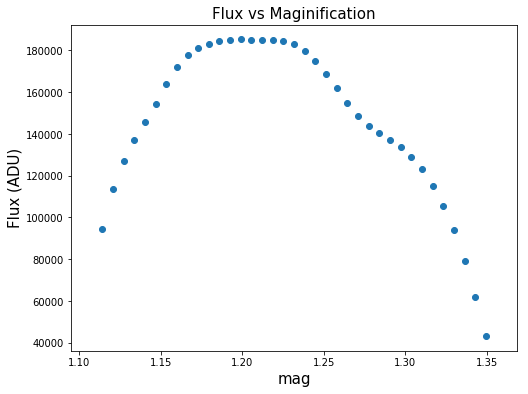

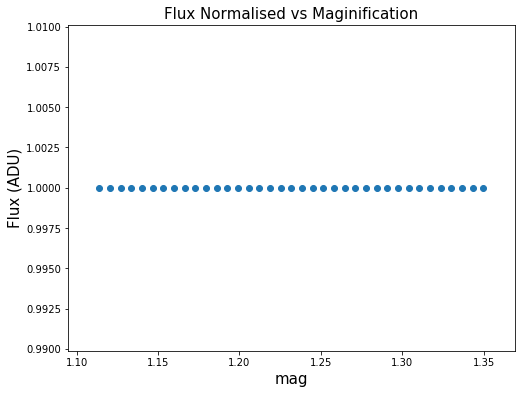

In [6]:
#Saving the new cube 250x250 pixels

scalefac = Med_mag                #I use the median magnification factor
out_dims = (250, 250)
star_cen = (star_ycen, star_xcen)

sdi1 = descale(Im_1, scalefac, out_dims, star_cen)
wfits(sdi1, 'sdi1_cube.fits')

#Checking the flux 
Im_1, He_1 = fits.getdata('sdi1_cube.fits', header = True)
Im_1 = np.nan_to_num(Im_1)
print('New cube shape:');print(Im_1.shape)

spot_sum = []

for i in range(37):
    
    spot_sum.append(np.sum(Im_1[i][108-4:108+4,174-4:174+4])) 
    
spot_sum = np.array(spot_sum)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux (ADU)', size = 15)
plt.title('Flux vs Maginification', size = 15);

#Sanity check: The spots should remain in the same box position in different images

# fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), ncols = 2, nrows = 1)

# A = axA.imshow(Im_1[12][108-4:108+4,174-4:175+4])
# axA.set_xlabel('pixels', size = 15)
# axA.set_ylabel('pixels', size = 15)
# axA.set_title('Spot position for image 12', size = 15)
# plt.colorbar(A, ax = axA)

# B = axB.imshow(Im_1[30][108-4:108+4,174-4:174+4])
# axB.set_xlabel('pixels', size = 15)
# axB.set_ylabel('pixels', size = 15)
# axB.set_title('Spot position for image 30', size = 15)
# plt.colorbar(B, ax = axB)

#Normalising the flux

sdi1_norm = []

for i in range(37):
    sdi1_norm.append(Im_1[i] / spot_sum[i])
    
wfits(sdi1_norm, 'sdi1_norm_cube.fits')

sdi1_norm = np.array(sdi1_norm)

#Sanity check for the normalization
spot_sum_2 = []
 
for i in range(37):
    
    spot_sum_2.append(np.sum(sdi1_norm[i][108-4:108+4,174-4:174+4])) 
    
spot_sum_2 = np.array(spot_sum_2)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum_2);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux (ADU)', size = 15)
plt.title('Flux Normalised vs Maginification', size = 15);

#Median subtraction and demagnification

Median          = np.median(sdi1_norm, axis = 0)
sdi1_norm_sub_2 = np.array(sdi1_norm - Median)

sdi1_norm_sub = []

for i in range(37):
    sdi1_norm_sub.append(sdi1_norm_sub_2[i] * spot_sum[i])
    
sdi1_norm_sub = np.array(sdi1_norm_sub)

scalefac = 1.0 / Med_mag
out_dims = (250, 250)
star_cen = (np.array(125), np.array(125))

sdi_out = descale(sdi1_norm_sub, scalefac, out_dims, star_cen)
wfits(sdi_out, 'sdi_out.fits')

**Q3 (1 point)** Collapse the data cube along the third dimension to make a 2D square image. Pick a display range in intensity that shows the planet, and draw a green circle around the location of the planet.

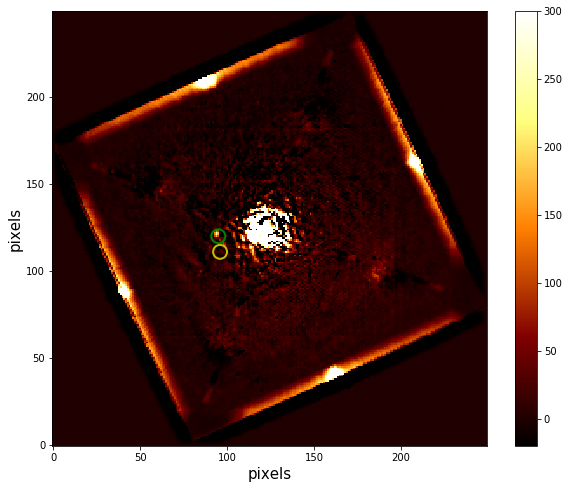

In [7]:
#Collapsing the cube along the third dimension

Mean_final = np.mean(sdi_out, axis  = 0)

wfits(Mean_final, 'Mean_final.fits')

X_planet = 95.0 ; Y_planet = 120.0   #Planet position
Y_Back   = 111.0; X_Back   = 96.0    #Background position

Circle = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)   #Planet
Circle_1 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)     #Background

plt.figure(figsize = (10,8))
ax = plt.gca()
plt.imshow(Mean_final, vmin = -20, vmax = 300, cmap = 'afmhot')
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
ax.add_artist(Circle)
ax.add_artist(Circle_1)
plt.colorbar();

**Q4 (1 point)** Determine the angular separation in pixels between the planet and star to an accuracy of 1 pixel. Print out this distance using a formatted print statement.

In [8]:
PScale = 0.0143 #arcsec/px

X_star   = 124.0 ; Y_star   = 124.0 #From Mean_final in DS9 (error = 1 pixel)
X_planet = 95.0 ; Y_planet = 120.0

Separation_pixels    = np.sqrt( (X_star - X_planet)**2 + (Y_star - Y_planet)**2 )
Sepration_pix_error  = 1.0 #After propagating 1pixels error in the last line 

print('The separation in pixels is: %d +/- %d'%(Separation_pixels, Sepration_pix_error))

The separation in pixels is: 29 +/- 1


**Q5 (1 point)** Assuming a pixel scale of $14.3\pm 0.1$ milliarcsec per pixel, determine the angular separation of the planet in arcseconds with an appropriate quoted error. Print using a formatted print statement.

In [9]:
#Determining the angular separation and propagating the error 

PScale_error = 0.001 #In arcsecs

Separation_arcsec       = Separation_pixels*PScale
Separation_arcsec_error = Separation_arcsec*((Sepration_pix_error/Separation_pixels) + (PScale_error/PScale))

print('The separation in arcsec is: %.2f +/- %.2f'%(Separation_arcsec, Separation_arcsec_error))

D_star       = 19.3 #Distance in pc to the star (2004ARA&A..42..685Z)
D_Star_error = 0.2

Separation_au       = D_star * Separation_arcsec
Separation_au_error = Separation_au*((D_Star_error/D_star) + (Separation_arcsec_error/Separation_arcsec))

print('The separation in astronomical units is: %.1f +/- %.1f'%(Separation_au, Separation_au_error))

The separation in arcsec is: 0.42 +/- 0.04
The separation in astronomical units is: 8.1 +/- 0.9


**Q6 (1 point)** Measure the flux of the planet using an aperture that is 100 milliarcseconds in diameter and centered on the planet. Print using a formatted print statement. 

Remember to estimate the sky background using a similar sized aperture at the same angular distance from the star but close to the location of the planet. 

Print the r.m.s. per pixel in the sky background aperture, and print the planet flux corrected for the sky background level.

In [10]:
#Background and planet flux using same aperture and same angular distance measured with DS9.

radius      = 4 #In pixels. Equivalent to 100 milliarcseconds in diameter.

Planet_flux = np.sum(Mean_final[int(Y_planet) - int(radius): int(Y_planet) + int(radius)\
                                , int(X_planet) - int(radius): int(X_planet) + int(radius)])

Background  = np.sum(Mean_final[int(Y_Back) - int(radius): int(Y_Back) + int(radius)\
                                , int(X_Back) - int(radius): int(X_Back) + int(radius)])

Background_rms  = np.sqrt(np.nanmean((Mean_final[int(Y_Back) - int(radius): int(Y_Back) + int(radius)\
                                , int(X_Back) - int(radius): int(X_Back) + int(radius)])**2)) 

print("The planet's flux is: %.2f ADU"%Planet_flux)
print("The background is: %.2f ADU"%Background)
print("The corrected planet's flux is: %.2f ADU"%(Planet_flux - Background))
print("The background RMS is: %.2f ADU"%Background_rms)

The planet's flux is: 2124.57 ADU
The background is: 172.41 ADU
The corrected planet's flux is: 1952.16 ADU
The background RMS is: 21.00 ADU


**Q7 (3 points)** Reduce the other 3 data cubes, and combine the 4 individual images to form a final higher signal to noise image, and display it with `imshow()` to show the planet. Estimate the total flux and error on the flux of the planet using the same sized apertures used earlier. 

Use the variance in these fluxes to estimate the signal to noise of the final combined image. Print out the total flux of the planet with an error to two decimal planes.

In [11]:
Im_1, He_1 = fits.getdata('c01.fits.gz', header = True) #Data cubes containing the exoplanet
Im_2, He_2 = fits.getdata('c02.fits.gz', header = True)
Im_3, He_3 = fits.getdata('c03.fits.gz', header = True)
Im_4, He_4 = fits.getdata('c04.fits.gz', header = True)

Im_1 = np.nan_to_num(Im_1) #Avoiding NAN-values in the images
Im_2 = np.nan_to_num(Im_2)
Im_3 = np.nan_to_num(Im_3)
Im_4 = np.nan_to_num(Im_4)

Images  = [Im_1, Im_2, Im_3, Im_4]
Headers = [He_1, He_2, He_3, He_4]

for j in range(4):
    
    X_star = Headers[j]['PSFCENTX']
    Y_star = Headers[j]['PSFCENTY']
    
    star_xcen         = []
    star_ycen         = []
    
    spot_separation_1 = []
    spot_separation_2 = []
    spot_separation_3 = []
    spot_separation_4 = []
    spot_separation_5 = []
    spot_separation_6 = []

    x, y = sat_spot_read(Headers[j])
    
    for i in range(37):
        
        star_xcen.append(np.mean([x[i][0], x[i][1], x[i][2], x[i][3]]))
        star_ycen.append(np.mean([y[i][0], y[i][1], y[i][2], y[i][3]]))
        
        Sp_0 = np.array([x[i][0], y[i][0]])
        Sp_1 = np.array([x[i][1], y[i][1]])
        Sp_2 = np.array([x[i][2], y[i][2]])
        Sp_3 = np.array([x[i][3], y[i][3]])

   
        spot_separation_1.append(np.linalg.norm(Sp_3-Sp_0))
        spot_separation_2.append(np.linalg.norm(Sp_2-Sp_1))
        spot_separation_3.append(np.linalg.norm(Sp_0-Sp_2))  #All possible distance combiantions
        spot_separation_4.append(np.linalg.norm(Sp_1-Sp_3))
        spot_separation_5.append(np.linalg.norm(Sp_1-Sp_0))
        spot_separation_6.append(np.linalg.norm(Sp_2-Sp_3))

    star_xcen = np.array(star_xcen)
    star_ycen = np.array(star_ycen) 
    
    spot_separation_1 = np.array(spot_separation_1)  
    spot_separation_2 = np.array(spot_separation_2)
    spot_separation_3 = np.array(spot_separation_3)
    spot_separation_4 = np.array(spot_separation_4)
    spot_separation_5 = np.array(spot_separation_5)
    spot_separation_6 = np.array(spot_separation_6)

    mag_1 = spot_separation_1[-1] / spot_separation_1
    mag_2 = spot_separation_2[-1] / spot_separation_2
    mag_3 = spot_separation_3[-1] / spot_separation_3            #All possible magnification factors
    mag_4 = spot_separation_4[-1] / spot_separation_4
    mag_5 = spot_separation_5[-1] / spot_separation_5
    mag_6 = spot_separation_6[-1] / spot_separation_6

    Med_mag = []

    for i in range(len(mag_1)):
        Med_mag.append(np.median([mag_1[i], mag_2[i], mag_3[i], mag_4[i], mag_5[i], mag_6[i]]))
    
    Med_mag = np.array(Med_mag)
    
    scalefac = Med_mag
    out_dims = (250, 250)
    star_cen = (star_ycen, star_xcen)

    sdi1 = descale(Images[j], scalefac, out_dims, star_cen)
    wfits(sdi1, 'sdi%d_cube.fits'%(j+1))
    
    Im, He = fits.getdata('sdi%d_cube.fits'%(j+1), header = True)
    Im = np.nan_to_num(Im)
    
    print('Working on Cube %d'%(j+1))
    print(Im.shape) 
    
    sdi1_norm = []

    for i in range(37):
        sdi1_norm.append(Im[i] / spot_sum[i])
    
    wfits(sdi1_norm, 'sdi%d_norm_cube.fits'%(j+1))

    sdi1_norm = np.array(sdi1_norm)
    
    Median          = np.median(sdi1_norm, axis = 0)
    sdi1_norm_sub_2 = np.array(sdi1_norm - Median)

    sdi1_norm_sub = []

    for i in range(37):
        sdi1_norm_sub.append(sdi1_norm_sub_2[i] * spot_sum[i])
    
    sdi1_norm_sub = np.array(sdi1_norm_sub)
    
    scalefac = 1.0 / Med_mag
    star_cen = (np.array(125), np.array(125))

    sdi_out = descale(sdi1_norm_sub, scalefac, out_dims, star_cen)
    wfits(sdi_out, 'sdi%d_out.fits'%(j+1))
    
    Mean_final = np.mean(sdi_out, axis  = 0)

    wfits(Mean_final, 'Mean_final_%d.fits'%(j+1))

Working on Cube 1
(37, 250, 250)
Working on Cube 2
(37, 250, 250)
Working on Cube 3
(37, 250, 250)
Working on Cube 4
(37, 250, 250)


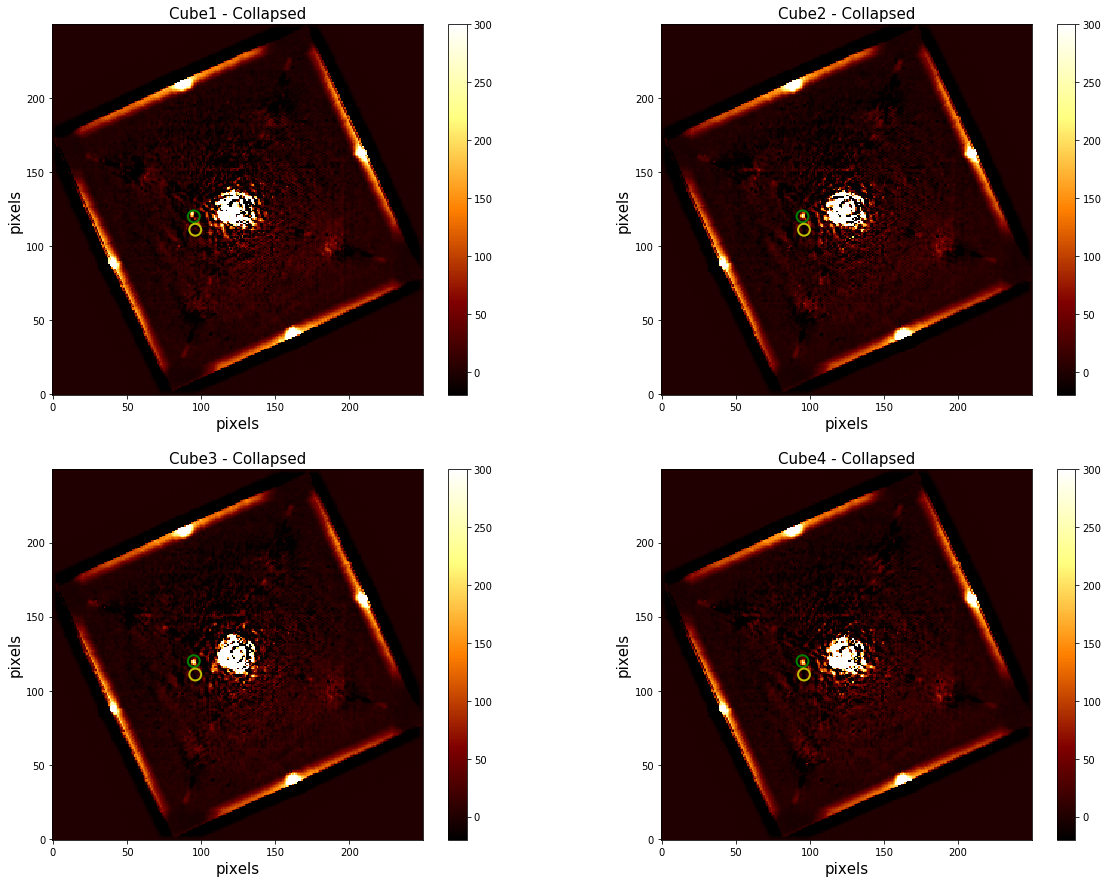

In [12]:
#Checking out the final images after collapsing the four data cubes

Mean_final_1 = fits.getdata('Mean_final_1.fits') #Data cubes containing the exoplanet
Mean_final_2 = fits.getdata('Mean_final_2.fits')
Mean_final_3 = fits.getdata('Mean_final_3.fits')
Mean_final_4 = fits.getdata('Mean_final_4.fits')

X_planet = 95.0 ; Y_planet = 120.0 
Y_Back   = 111.0; X_Back   = 96.0 

Circle_1   = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)  
Circle_2   = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)
Circle_3   = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)
Circle_4   = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)

Circle_5 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)
Circle_6 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)
Circle_7 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)
Circle_8 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize = (20,15), ncols = 2, nrows = 2) 

A = axA.imshow(Mean_final_1, vmin = -20, vmax = 300, cmap = 'afmhot')
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.add_artist(Circle_1)
axA.add_artist(Circle_5)
axA.set_title('Cube1 - Collapsed', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(Mean_final_2, vmin = -20, vmax = 300, cmap = 'afmhot')
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.add_artist(Circle_2)
axB.add_artist(Circle_6)
axB.set_title('Cube2 - Collapsed', size = 15)
plt.colorbar(B, ax = axB)

C = axC.imshow(Mean_final_3, vmin = -20, vmax = 300, cmap = 'afmhot')
axC.set_xlabel('pixels', size = 15)
axC.set_ylabel('pixels', size = 15)
axC.add_artist(Circle_3)
axC.add_artist(Circle_7)
axC.set_title('Cube3 - Collapsed', size = 15)
plt.colorbar(C, ax = axC)

D = axD.imshow(Mean_final_4, vmin = -20, vmax = 300, cmap = 'afmhot')
axD.set_xlabel('pixels', size = 15)
axD.set_ylabel('pixels', size = 15)
axD.add_artist(Circle_4)
axD.add_artist(Circle_8)
axD.set_title('Cube4 - Collapsed', size = 15)
plt.colorbar(D, ax = axD);

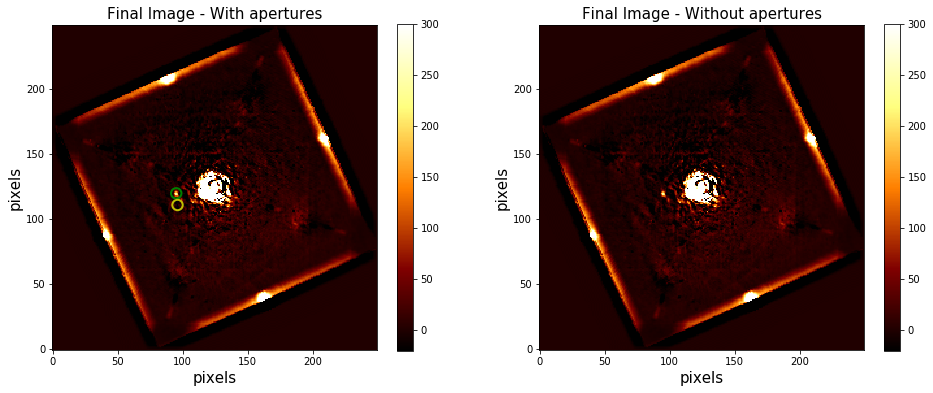

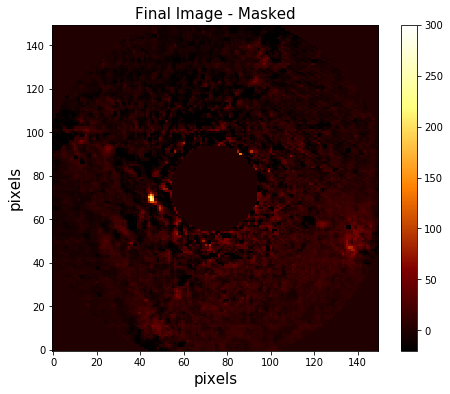

In [13]:
Final_Result = np.nanmedian([Mean_final_1, Mean_final_2, Mean_final_3, Mean_final_4], axis = 0)

X_planet = 95.0 ; Y_planet = 120.0   #Planet position
Y_Back   = 111.0; X_Back   = 96.0    #Background position

Circle = plt.Circle((X_planet, Y_planet), 4, color = 'g', fill = False, lw = 2)   #Planet
Circle_1 = plt.Circle((X_Back, Y_Back), 4, color = 'y', fill = False, lw = 2)     #Background                                    s

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))
    
Mask_1 = circle_mask(Final_Result, xc = 124, yc = 124, rcirc = 20)    
Mask_2 = circle_mask(Final_Result, xc = 124, yc = 124, rcirc = 80)   
Mask_2 = [*~Mask_2] 
Masked = Final_Result*~np.logical_or(Mask_1, Mask_2)

fig, ((axA, axB)) = plt.subplots(figsize = (16,6), ncols = 2, nrows = 1) 

A = axA.imshow(Final_Result, vmin = -20, vmax = 300, cmap = 'afmhot')
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.add_artist(Circle)
axA.add_artist(Circle_1)
axA.set_title('Final Image - With apertures', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(Final_Result, vmin = -20, vmax = 300, cmap = 'afmhot')
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('Final Image - Without apertures', size = 15)
plt.colorbar(B, ax = axB)

plt.figure(figsize = (8,6))
plt.imshow(Masked[50:200, 50:200], vmin = -20, vmax = 300, cmap = 'afmhot')
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.title('Final Image - Masked', size = 15)
plt.colorbar();

wfits(Final_Result, 'Final_Result.fits')
wfits(Masked[50:200, 50:200], 'Final_Result_masked.fits')

In [14]:
radius = 4 

Planet_flux_final = np.sum(Final_Result[int(Y_planet) - int(radius): int(Y_planet) + int(radius)\
                                , int(X_planet) - int(radius): int(X_planet) + int(radius)])

Background_final  = np.sum(Final_Result[int(Y_Back) - int(radius): int(Y_Back) + int(radius)\
                                , int(X_Back) - int(radius): int(X_Back) + int(radius)])

Final_Images = [Mean_final_1, Mean_final_2, Mean_final_3, Mean_final_4]
Fluxes       = []
Backgrounds  = []

for i in range(4):
    
    Fluxes.append(np.sum(Final_Images[i][int(Y_planet) - int(radius): int(Y_planet) + int(radius)\
                                , int(X_planet) - int(radius): int(X_planet) + int(radius)]))
    
    Backgrounds.append(np.sum(Final_Images[i][int(Y_Back) - int(radius): int(Y_Back) + int(radius)\
                                , int(X_Back) - int(radius): int(X_Back) + int(radius)]))
    
SN         = np.var(Fluxes)/np.var(Backgrounds) #Signal-to-Noise ratio
Flux_error = (1.0/SN)*Planet_flux_final 

print("The corrected planet flux in the final image is: (%.2f +/- %.2f) ADU"%((Planet_flux_final-Background_final), Flux_error))

The corrected planet flux in the final image is: (2237.00 +/- 305.64) ADU
